In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F

from tctct import TCTCT_Layer, _TCTCT_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [3]:
temp[0].shape

NameError: name 'temp' is not defined

In [4]:
sp1 = dict(in_features=1, 
           tau_min=1, tau_max=25.0, buff_max=45,
           dt=1, ntau=50, g=0.0, ttype=ttype, 
           channels=10, kernel_width=5, dilation=1)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=1, tau_max=100.0, buff_max=225,
           dt=1, ntau=200, g=0.0, ttype=ttype, 
           channels=15, kernel_width=5, dilation=1)
t1 = _TCTCT_Core(sp1).cuda()
act_func = nn.ReLU()
batch_norm = nn.BatchNorm1d(t1.channels).cuda()

t2 = _TCTCT_Core(sp2).cuda()

In [5]:
out1 = t1(temp[0])
out1 = act_func(out1)
out1 = out1.reshape(32, 117, -1)
print(out1.shape)
out1 = out1.transpose(2,1)
out1 = batch_norm(out1).transpose(2,1)


#.reshape(32, 117, -1).transpose(2,1).unsqueeze(1)
#out2 = t2(out1).reshape(32, 117, -1).transpose(2,1).unsqueeze(1)
#print(out1.shape, out2.shape)

NameError: name 'temp' is not defined

In [21]:
class TCTCT_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(TCTCT_Classifier, self).__init__()
        last_channels = sum([l['channels'] for l in layer_params])
        self.tctct_layers = nn.ModuleList([TCTCT_Layer(l) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
    def forward(self, inp):
        
        x = inp
        out = []
        for i, l in enumerate(self.tctct_layers[:-1]):
            x = l(x)
            out.append(x.clone())
            
        #x = self.to_out(torch.concat(out, dim=-1))
        
        return x

In [22]:
sp1 = dict(in_features=1, 
           tau_min=1, tau_max=25.0, buff_max=45,
           dt=1, ntau=50, g=0.0, ttype=ttype, 
           channels=10, kernel_width=5, dilation=1)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=1, tau_max=100.0, buff_max=225,
           dt=1, ntau=200, g=0.0, ttype=ttype, 
           channels=10, kernel_width=5, dilation=1)

layer_params = [sp1, sp2]

model = TCTCT_Classifier(8, layer_params, act_func=nn.ReLU, 
                         batch_norm=False, dropout=0).cuda()


In [14]:
def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, perf_file,
          permute=None, loss_buffer_size=64, batch_size=4, device='cuda',
          prog_bar=None, maxn=6):
    
    assert(loss_buffer_size%batch_size==0)
        
    losses = []
    perfs = []
    last_test_perf = 0
    best_test_perf = -1
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out[:, -1, :],
                         target)

        loss.backward()
        optimizer.step()

        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      target).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, perf: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           np.sum(perfs)/((len(perfs))*batch_size), last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            last_test_perf = test(model, 'cuda', test_loader, 
                                  batch_size=batch_size, 
                                  permute=permute)
            loss_track['avg_loss'] = np.mean(losses)
            loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            loss_track['pres_num'] = batch_idx*batch_size + epoch*len(train_loader.dataset)
            loss_track['maxn'] = maxn
            loss_track['train_perf']= np.sum(perfs)/((len(perfs))*batch_size)
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
            if best_test_perf < last_test_perf:
                torch.save(model.state_dict(), perf_file[:-4]+".pt")
                best_test_perf = last_test_perf

                
def test(model, device, test_loader, batch_size=4, permute=None):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            out = model(data)
            pred = out[:, -1].argmax(dim=-1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += 1
    return correct / len(test_loader.dataset)

In [8]:
def generate_noise(maxn=18):
    """Generates dot and dash based noise."""
    
    threes = np.random.randint(int(.5*maxn), int(.75*maxn))
    ones = (maxn - threes) * 2
    noise = list(itertools.repeat([1,1,1,0], threes))
    noise[:int(len(noise)/3)] = list(itertools.repeat([0,0], int(len(noise)/3)))
    ones = ones + int(len(noise)/3)
    noise.extend(list(itertools.repeat([1,0], ones)))
    random.shuffle(noise)
    noise = np.concatenate(noise)
    return noise

In [34]:
temp = next(enumerate(dataset))[1]
print(temp[0].shape)

torch.Size([32, 1, 1, 113])


In [37]:
x = temp[0]
out = []
for i, l in enumerate(model.tctct_layers):
    x = l(x)
    out.append(x.clone())
    print(x.shape)
x = x.squeeze(1).transpose(1,2)
print(x.shape)
print(model(temp[0]))

torch.Size([32, 1, 10, 113])
torch.Size([32, 1, 10, 113])
torch.Size([32, 113, 10])


RuntimeError: size mismatch, m1: [3616 x 10], m2: [20 x 8] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [11]:
x = self.to_out(torch.concat(out, dim=-1))

NameError: name 'self' is not defined

In [86]:

signals = ttype([[0,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0],
                 [0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,0],
                 
                 [0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0],
                 [0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0],

                ]
               ).view(8, 1, 1, -1)
signals2 = signals.unsqueeze(-1).repeat(1,1,1,1,2).reshape(8,1,1,-1)

In [111]:
batch_size=8
classes = torch.LongTensor(np.arange(0,8)).reshape(8,1)
training_signals = signals.cuda()
training_class  = classes.cuda().squeeze(-1)
dataset = torch.utils.data.TensorDataset(training_signals, training_class)
dataset = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

training_signals2 = signals2.cuda()
training_class2  = classes.cuda().squeeze(-1)
dataset2 = torch.utils.data.TensorDataset(training_signals2, training_class2)
dataset2 = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=True)



In [109]:
sp1 = dict(in_features=1, 
           tau_min=1, tau_max=100.0, buff_max=225,
           dt=1, ntau=200, g=0.0, ttype=ttype, 
           channels=20, kernel_width=10, dilation=1)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=1, tau_max=100.0, buff_max=225,
           dt=1, ntau=200, g=0.0, ttype=ttype, 
           channels=20, kernel_width=10, dilation=2)

layer_params = [sp1,
               sp2
               ]

model = TCTCT_Classifier(8, layer_params, act_func=nn.ReLU, 
                         batch_norm=False, dropout=0.).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
#print(model)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.005)
epochs = 10000

progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for e in progress_bar:
    train(model, ttype, dataset, dataset, 
          optimizer, loss_func, batch_size=batch_size,
          epoch=e, perf_file=join('perf','h8_tctct_norm.csv'),
          loss_buffer_size=batch_size*4,
          prog_bar=progress_bar, maxn=maxn)

Total Weights: 4488


Exception ignored in: <generator object tqdm.__iter__ at 0x7f975967fca8>
Traceback (most recent call last):
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/std.py", line 1182, in __iter__
    self.close()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/notebook.py", line 240, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/std.py", line 1270, in close
    self._decr_instances(self)
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, tim

KeyboardInterrupt: 

In [110]:
for temp in dataset:
    print(temp[0].shape)
    out = model(temp[0])
    print( out[:, -1].argmax(dim=-1, keepdim=True).detach().cpu().numpy(),
          temp[1].detach().cpu().numpy())

torch.Size([8, 1, 1, 17])
[[7]
 [2]
 [3]
 [5]
 [1]
 [6]
 [4]
 [0]] [7 2 3 5 1 6 4 0]


In [112]:
for temp in dataset2:
    print(temp[0].shape)
    out = model(temp[0])
    print( out[:, -1].argmax(dim=-1, keepdim=True).detach().cpu().numpy(),
          temp[1].detach().cpu().numpy())

torch.Size([8, 1, 1, 34])
[[1]
 [4]
 [4]
 [0]
 [3]
 [3]
 [1]
 [1]] [7 4 5 0 3 6 1 2]


# Setup Classifier type model

# Training and testing

In [15]:
# You likely don't need this to be this long, but just in case.
epochs = 1000

# Just for visualizing average loss through time. 
loss_buffer_size = 100

In [16]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = int(args[2])
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

   direc: array([[0.55507915]])
     fun: 0.1347234
 message: 'Optimization terminated successfully.'
    nfev: 46
     nit: 2
  status: 0
 success: True
       x: array(17.20967488)
ntau: 15 k: 17


/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


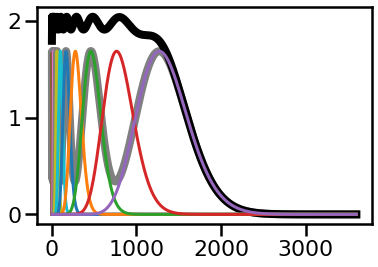

In [69]:
ntau_0 = 15
k_0 = 20
tau_min = 1.
tau_max = 1200.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau_0), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)
ntau=ntau_0
k = int(res.x)
print('ntau:', ntau, 'k:', k)
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, k=k, ntau=ntau, dt=1.0, g=1.0)
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
        linewidth=8, color='grey');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );

In [108]:
class TCTCT_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(TCTCT_Classifier, self).__init__()
        #last_channels = sum([l['channels'] for l in layer_params])
        last_channels =  layer_params[-1]['channels']
        self.tctct_layers = nn.ModuleList([TCTCT_Layer(l) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
    def forward(self, inp):
        
        x = inp
        out = []
        for i, l in enumerate(self.tctct_layers):
            x = l(x)
            #out.append(x.clone())
        x = x.squeeze(1).transpose(1,2)
        x = self.to_out(x)
        
        return x

In [27]:
import matplotlib.pylab as plt
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sn
sn.set_context('talk')

In [114]:
test_noise_lengths = [8][::-1]
batch_size = 16
for maxn in test_noise_lengths:
    torch.manual_seed(12345)
    np.random.seed(12345)
    training_samples = 64
    training_signals = []
    training_class = []
    for i, sig in enumerate(signals):
        temp_signals = []
        temp_class = []
        for x in range(training_samples):
            noise = ttype(generate_noise(maxn))
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            c=0
            while(any([(temp == c_).all() for c_ in temp_signals])):
                noise = ttype(generate_noise(maxn))
                temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
                #temp = sig[0,0].unsqueeze(0).unsqueeze(0).unsqueeze(0)
                c += 1
                if c == 100:
                    1/0
            temp_signals.append(temp)
            temp_class.append(i)
        training_signals.extend(temp_signals)
        training_class.extend(temp_class)
    batch_rand = torch.randperm(training_samples*signals.shape[0])        
    training_signals = torch.cat(training_signals).cuda()[batch_rand]
    training_class  = ctype(training_class).cuda()[batch_rand]
    dataset = torch.utils.data.TensorDataset(training_signals, training_class)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    testing_samples = 10
    testing_signals = []
    testing_class = []
    for i, sig in enumerate(signals):
        temp_signals = []
        temp_class = []
        for x in range(testing_samples):
            noise = ttype(generate_noise(maxn))
            temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
            while(any([(temp == c_).all() for c_ in temp_signals]) or any([(temp == c_).all() for c_ in training_signals])):
                noise = ttype(generate_noise(maxn))
                temp = torch.cat([sig[0,0], noise]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
                #temp = sig[0,0].unsqueeze(0).unsqueeze(0).unsqueeze(0)
            temp_signals.append(temp)
            temp_class.append(i)
        testing_signals.extend(temp_signals)
        testing_class.extend(temp_class)
    batch_rand = torch.randperm(testing_samples*signals.shape[0])

    testing_signals = torch.cat(testing_signals).cuda()[batch_rand]
    testing_class  = ctype(testing_class)[batch_rand]


    dataset_valid = torch.utils.data.TensorDataset(testing_signals, testing_class)
    dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
    sp1 = dict(in_features=1, 
               tau_min=1, tau_max=25.0, buff_max=45,
               dt=1, ntau=50, g=0.0, ttype=ttype, 
               channels=20, kernel_width=10, dilation=1)
    sp2 = dict(in_features=sp1['channels'], 
               tau_min=1, tau_max=100.0, buff_max=225,
               dt=1, ntau=200, g=0.0, ttype=ttype, 
               channels=20, kernel_width=20, dilation=1)

    layer_params = [sp1, sp2]

    model = TCTCT_Classifier(8, layer_params, act_func=nn.ReLU, 
                             batch_norm=False, dropout=0.0).cuda()

    tot_weights = 0
    for p in model.parameters():
        tot_weights += p.numel()
    print("Total Weights:", tot_weights)
    #print(model)

    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 5e-4)
    epochs = 10000
    
    progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

    for e in progress_bar:
        train(model, ttype, dataset, dataset_valid, 
              optimizer, loss_func, batch_size=batch_size,
              epoch=e, perf_file=join('perf','h8_tctct4.csv'),
              loss_buffer_size=batch_size,
              prog_bar=progress_bar, maxn=maxn)

Total Weights: 8488


Exception ignored in: <generator object tqdm.__iter__ at 0x7f97596af570>
Traceback (most recent call last):
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/std.py", line 1182, in __iter__
    self.close()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/notebook.py", line 240, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/std.py", line 1270, in close
    self._decr_instances(self)
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/home/bgj5hk/bin/anaconda3/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, tim

KeyboardInterrupt: 

In [116]:
test2 = testing_signals.unsqueeze(-1).repeat(1,1,1,1,2).view(testing_signals.shape[0],
                                                     testing_signals.shape[1],
                                                     testing_signals.shape[2],
                                                     -1)

In [117]:
dataset_valid = torch.utils.data.TensorDataset(test2, testing_class)
dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [119]:
test(model, 'cuda', dataset_valid, 
      batch_size=batch_size, 
      permute=None)

0.125

In [68]:
dat = pd.read_csv('perf/h8_tctct3.csv')
maxpres = 8

dat['presnum_epoch'] = ((dat.batch_idx) + maxpres*dat.epoch)/maxpres
datgb = dat.groupby(['maxn'])
datgb.describe()['last_test']['max']
print(dat)

      avg_loss  last_test  epoch  batch_idx  pres_num  maxn  train_perf  \
0     2.178248     0.1250      0          1        16     8      0.0625   
1     2.211807     0.1250      0          2        32     8      0.1250   
2     1.980944     0.1250      0          3        48     8      0.4375   
3     2.149568     0.1250      0          4        64     8      0.1875   
4     2.104926     0.1250      0          5        80     8      0.1875   
...        ...        ...    ...        ...       ...   ...         ...   
4601  2.070917     0.1125    148         14     76000     8      0.0625   
4602  2.144299     0.1125    148         15     76016     8      0.0625   
4603  2.077913     0.1125    148         16     76032     8      0.1875   
4604  2.035784     0.1000    148         17     76048     8      0.1875   
4605  1.995614     0.1000    148         18     76064     8      0.1875   

      presnum_epoch  
0             0.125  
1             0.250  
2             0.375  
3          

Text(0.5, 1.0, 'DeepSITH')

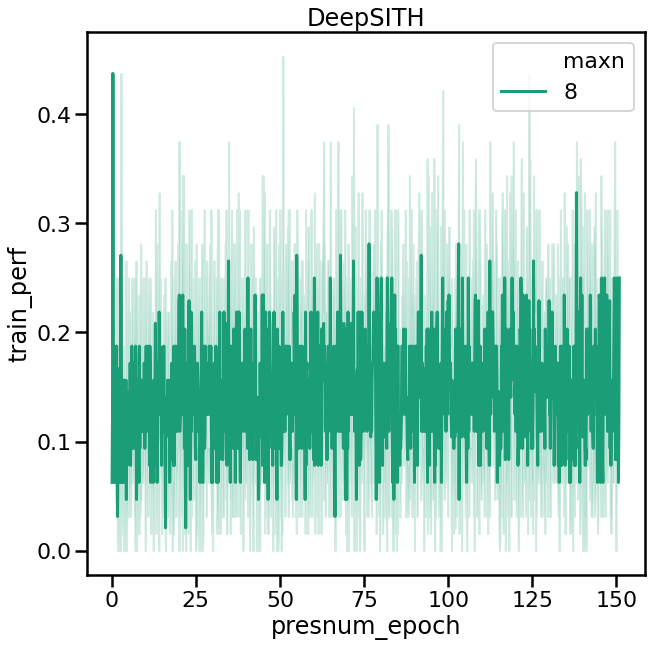

In [69]:
sn.set_context("poster")

fig = plt.figure(figsize=(10,10))
sn.lineplot(data=dat, y='train_perf', x='presnum_epoch', hue='maxn',
           palette='Dark2')
plt.title('DeepSITH')
#plt.xlim(0,20)

Text(0.5, 1.0, 'DeepSITH')

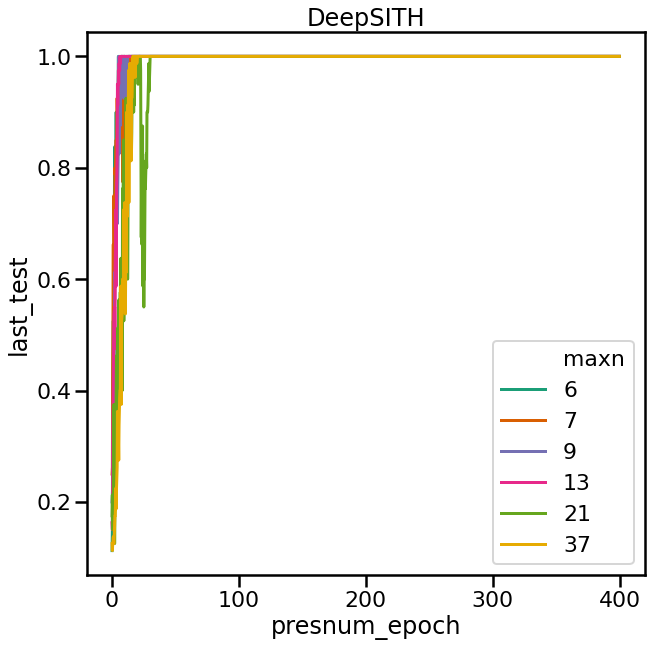

In [130]:
dat = pd.read_csv(join('perf','h8_LMU_length_6.csv'))

dat['presnum_epoch'] = ((dat.batch_idx*32) + maxpres*dat.epoch)/maxpres
datgb = dat.groupby(['maxn'])
datgb.describe()['last_test']['max']
sn.set_context("poster")

fig = plt.figure(figsize=(10,10))
sn.lineplot(data=dat, y='last_test', x='presnum_epoch', hue='maxn',
           palette='Dark2')
plt.title('DeepSITH')